
## Taller de Procesamiento de Señales - TP5 SVM
### Alumno: Julián Stejman

--- 


Un géiser es un tipo especial de fuente hidrotermal que emite esporádicamente una columna
de agua caliente y vapor al aire. Se desea clasificar el tipo de erupción de Yellowstone National
Park (EEUU) a partir del tiempo de espera hasta la erupción y la duración de la misma.

Para esto se utilizarán máquinas de vectores soporte o SVM's.

In [219]:
from seaborn import load_dataset
import pandas as pd

geyser_ds = load_dataset("geyser")
geyser_ds_labels = []
for kind in geyser_ds["kind"]:
    if kind == "long":
        geyser_ds_labels.append(1)
    elif kind == "short":
        geyser_ds_labels.append(-1)  
geyser_ds_labels = pd.DataFrame(geyser_ds_labels).values.ravel()
geyser_ds.drop(columns=["kind"], inplace=True)


In [220]:
from qpsolvers import solve_qp
%pip install qpsolvers[osqp] --quiet
import numpy as np

Note: you may need to restart the kernel to use updated packages.


Se escribe la clase SVM que resuelve el problema primal y dual en ambos casos considerando lo que sucede al relajar los márgenes. Se ponen en el siguiente formato para poder resolver estos problemas de programación cuadrática
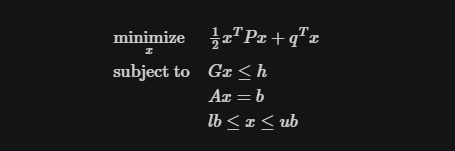

In [221]:
class SVM:
    def __init__(self, C=1e-4, problem="primal", threshold=1e-4):
        self.C = C 
        self.problem = problem
        self.threshold = threshold
        self._fitted = False
        self.w = None
        self.b = None

    def _fit_primal(self, X, y):
        n_samples, n_features = X.shape
        # Se crean las matrices para el problema primal
        P = np.zeros((n_features + 1 + n_samples, n_features + 1 + n_samples))
        P[:n_features, :n_features] = np.eye(n_features) # esto corresponde a los w
        P[n_features, n_features] = 0 # esto corresponde al bias

        C_value = 1e-4 if self.C == 0 else self.C # planteo un valor mínimo para márgenes sin relajar
        P[n_features + 1:, n_features + 1:] = np.eye(n_samples) * C_value # esto corresponde a los slack variables
        q = np.zeros(n_features + 1 + n_samples) 
        q[n_features+1:] = C_value # esto hace que la función objetivo sea minimizar C*sum(ξ_i)
        
        G = np.zeros((n_samples, n_features + 1 + n_samples))
        h = np.ones(n_samples) * -1

        for i in range(n_samples):
            # los términos son negativos para que se cumpla que -yXw - b <= -1
            # yXw + b >= 1
            G[i, :n_features] = -y[i] * X[i] # términos w
            G[i, n_features] = -y[i] # término b
            G[i, n_features + 1 + i] = -1 # slack variable
        
        # Se agrega la restricción de que los slack variables son mayores o iguales a 0
        # ξ_i >= 0 → -ξ_i <= 0
        G_slack = np.zeros((n_samples, n_features + 1 + n_samples))
        G_slack[:, n_features + 1:] = -np.eye(n_samples)
        h_slack = np.zeros(n_samples)
        
        G = np.vstack((G, G_slack))
        h = np.hstack((h, h_slack))
        
        sol = solve_qp(P, q, G, h, solver="osqp")
        self.w = sol[:n_features]
        self.b = sol[n_features]

    def _fit_dual(self, X, y): 
        n_samples, n_features = X.shape
        # Kernel trick: K[i,j] = x_i · x_j
        K = X @ X.T  
        # Matriz P del problema dual: P[i,j] = y_i y_j K[i,j]
        P = np.outer(y, y) * K  
        q = -np.ones(n_samples)
        
        # Restricciones: 
        # 1) α_i ≥ 0 → -α_i ≤ 0
        # 2) α_i ≤ C
        C_value = np.inf if self.C == 0 else self.C
        G = np.vstack((-np.eye(n_samples), np.eye(n_samples)))
        h = np.hstack((np.zeros(n_samples), C_value * np.ones(n_samples)))
        
        # Restricción de igualdad: Σ α_i y_i = 0
        A = y.reshape(1, -1)
        b = np.array([0.0])
        
        sol = solve_qp(P, q, G, h, A, b, solver="osqp")
        
        # Calculamos w = Σ α_i y_i x_i
        self.w = np.zeros(n_features)
        for i in range(n_samples):
            self.w += sol[i] * y[i] * X[i]
        
        margin_sv = (sol > self.threshold) & (sol < C_value - self.threshold)
        
        if np.any(margin_sv):
            # b = promedio(y_i - w·x_i) para vectores en el margen
            self.b = np.mean(y[margin_sv] - X[margin_sv] @ self.w)
        else:
            self.b = 0
        
    def fit(self, X, y):
        self._fitted = True
        if self.problem == "primal":
            return self._fit_primal(X, y)
        elif self.problem == "dual":
            return self._fit_dual(X, y)

    def predict(self, X):
        if not self._fitted:
            raise Exception("Model not fitted yet.")
        return np.sign(X @ self.w + self.b)

#### Desarrollo matemático relajando los márgenes para el problema dual
Si se trabaja con el problema primal relajando los márgenes se obtiene la siguiente expresión 
$$
\min_{w,b,\xi} \frac{1}{2} ||w||^2 +C\sum_{i=0}^n \xi_i
$$

Considerando las restricciones de $y_i(w^Tx_i+B) \geq 1-\xi_i$ y además que $\xi_i \geq 0$ se plantean los multiplicadores de Lagrange para resolver el problema dual relajando los márgenes.
$$
J_1 = \min_{w,b,\xi} \max_{\alpha_i, \beta_i \geq 0 } \frac{1}{2} ||w||^2 +C\sum_{i=0}^n \xi_i - \sum_{i=0}^n \alpha_i(y_i(w^Tx_i+b)-1+\xi_i) - \sum_{i=0}^n \beta_i\xi_i
$$

Se intercambia el orden de maximo y mínimo dado que es equivalente en un problema convexo

$$
J_2 = \max_{\alpha_i, \beta_i \geq 0 } \min_{w,b,\xi}  \frac{1}{2} ||w||^2 +C\sum_{i=0}^n \xi_i - \sum_{i=0}^n \alpha_i(y_i(w^Tx_i+b)-1+\xi_i) - \sum_{i=0}^n \beta_i\xi_i
$$

$$
J_2 = \max_{\alpha_i, \beta_i \geq 0 } \min_{w,b,\xi} L(\alpha, \beta, w, b, \xi)
$$

Se hayan las derivadas parciales de L respecto a los parámetros a minimizar

$$
\frac{\partial{L}}{\partial{w}} = w - \sum_{i=0}^n \alpha_i y_i x_i = 0
\implies w = \sum_{i=0}^n \alpha_i y_i x_i
$$

$$
\frac{\partial{L}}{\partial{b}} = \sum_{i=0}^n \alpha_i y_i = 0 \implies \alpha^Ty = 0 
$$
Para algún $\xi_i$ con $0\leq i\leq n$ plantea la derivada parcial
$$
\frac{\partial{L}}{\partial{\xi_i}} = C - \alpha_i - \beta_i = 0 \implies \beta_i = C - \alpha_i
$$
$$
\beta_i \geq 0 \implies C - \alpha_i \geq 0 \implies \alpha_i \leq C
$$
Se puede reescribir las sumas dentro de $J_2$ de la siguiente forma:

$$
\sum_{i=0}^n \alpha_i(y_i(w^Tx_i+b)-1+\xi_i) + \sum_{i=0}^n \beta_i\xi_i = \underbrace{w^T \sum_{i=0}^n \alpha_i y_i  x_i}_{||w||^2} + b \underbrace{\sum_{i=0}^n \alpha_i y_i}_0 - \sum_{i=0}^n \alpha_i + \underbrace{\sum_{i=0}^n (\alpha_i + \beta_i)\xi_i}_{C\sum_{i=0}^n \xi_i}
$$

Reescribiendo $J_2$ en estos términos:

$$
J_2 = \max_{\alpha_i \geq 0 } \frac{1}{2}||w||^2 + C\sum_{i=0}^n \xi_i - \left[ ||w||^2 - \sum_{i=0}^n \alpha_i + C\sum_{i=0}^n \xi_i\right]
$$


$$
J_2 =  \max_{\alpha_i \geq 0 } \sum_{i=0}^n \alpha_i - \frac{1}{2}||w||^2 = \max_{\alpha_i \geq 0 } \sum_{i=0}^n \alpha_i - \frac{1}{2}\alpha^T Q \alpha
$$

$$
\alpha^Ty = 0 \qquad 0 \leq\alpha_i\leq C
$$

Se ve que el problema dual relajando los márgenes plantea una cota superior a los $\alpha_i$ sin cambiar la estructura de la expresión original

In [222]:
primal = SVM(C = 0,problem="primal")
primal_soft1 = SVM(C=0.001, problem="primal")
primal_soft2 = SVM(C=0.1, problem="primal")
dual = SVM(C=0, problem="dual")
dual_soft1 = SVM(C=0.001, problem="dual")
dual_soft2 = SVM(C=0.1, problem="dual")

Se puede ver a grandes rasgos que se logra en todos estos modelos separar los tipos de erupciones. 

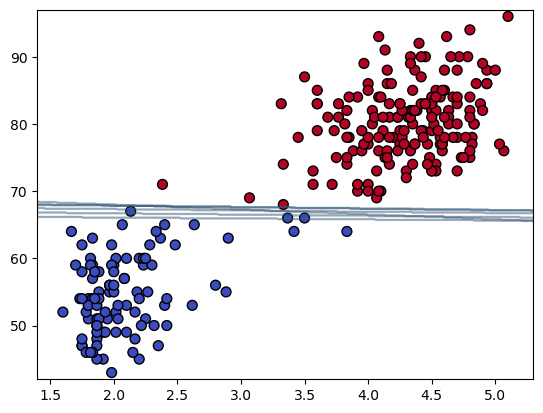

In [223]:
import warnings

import matplotlib.pyplot as plt

primal.fit(geyser_ds.values, geyser_ds_labels)
primal_soft1.fit(geyser_ds.values, geyser_ds_labels)
primal_soft2.fit(geyser_ds.values, geyser_ds_labels)
dual.fit(geyser_ds.values, geyser_ds_labels)
dual_soft1.fit(geyser_ds.values, geyser_ds_labels)
dual_soft2.fit(geyser_ds.values, geyser_ds_labels)

# Plot the decision boundary for each SVM
x_min, x_max = geyser_ds.values[:, 0].min() - 1, geyser_ds.values[:, 0].max() + 1
y_min, y_max = geyser_ds.values[:, 1].min() - 1, geyser_ds.values[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
def Z(model): 
    return (model.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

# Plot the decision boundary
fig, ax = plt.subplots()
ax.scatter(geyser_ds.values[:, 0], geyser_ds.values[:, 1], c=geyser_ds_labels, cmap="coolwarm", s=50, edgecolors="k")
ax.contour(xx, yy, Z(primal), levels=[-1, 0, 1], alpha=0.3)
ax.contour(xx, yy, Z(primal_soft1), levels=[-1, 0, 1], alpha=0.3)
ax.contour(xx, yy, Z(primal_soft2), levels=[-1, 0, 1], alpha=0.3)
ax.contour(xx, yy, Z(dual), levels=[-1, 0, 1], alpha=0.3)
ax.contour(xx, yy, Z(dual_soft1), levels=[-1, 0, 1], alpha=0.3)
ax.contour(xx, yy, Z(dual_soft2), levels=[-1, 0, 1], alpha=0.3)
ax.set_xlim(1.4, 5.3)

warnings.filterwarnings("ignore")
plt.show()


Se ve que inicialmente sin relajar márgenes al resolver el problema dual se logra una mayor accuracy dividiendo las clases.

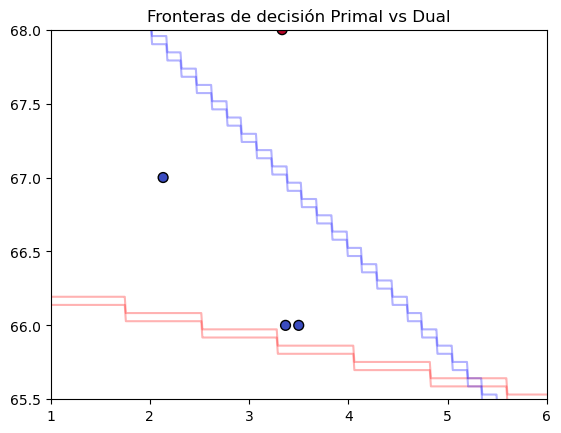

In [224]:
fig2, ax2 = plt.subplots()
ax2.scatter(geyser_ds.values[:, 0], geyser_ds.values[:, 1], c=geyser_ds_labels, cmap="coolwarm", s=50, edgecolors="k")
ax2.contour(xx, yy, Z(primal), levels=[-1, 0, 1], alpha=0.3, colors="red", linestyles="solid")
ax2.contour(xx, yy, Z(dual), levels=[-1, 0, 1], alpha=0.3, colors="blue", linestyles="solid")
plt.title("Fronteras de decisión Primal vs Dual")
ax2.set_xlim(1, 6)
ax2.set_ylim(65.5, 68)
plt.show()

Al relajar márgenes en el problema primal se ve que al lograr tener más vectores soporte hacia arriba, las fronteras de decisión suben y se van ajustando las pendientes acorde a esto. 

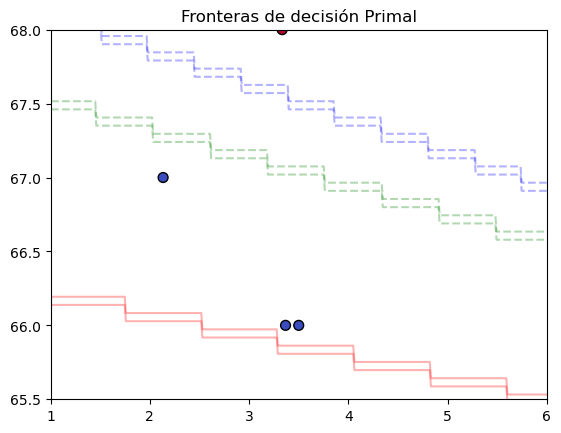

In [225]:


fig2, ax2 = plt.subplots()
ax2.scatter(geyser_ds.values[:, 0], geyser_ds.values[:, 1], c=geyser_ds_labels, cmap="coolwarm", s=50, edgecolors="k")
ax2.contour(xx, yy, Z(primal), levels=[-1, 0, 1], alpha=0.3, colors="red", linestyles="solid")
ax2.contour(xx, yy, Z(primal_soft1), levels=[-1, 0, 1], alpha=0.3, colors="green", linestyles="dashed")
ax2.contour(xx, yy, Z(primal_soft2), levels=[-1, 0, 1], alpha=0.3, colors="blue", linestyles="dashed")
plt.title("Fronteras de decisión Primal")
ax2.set_xlim(1, 6)
ax2.set_ylim(65.5, 68)
plt.show()

Al relajar márgenes en el problema dual sucede que al principio si el valor de C es muy bajo se tienen pocos vectores soporte haciendo que tenga peor accuracy porque las fronteras de decisión están más bajas, luego mejora eso al subir el valor de C, en definitiva dándole lugar a valores mayores de $\alpha_i$

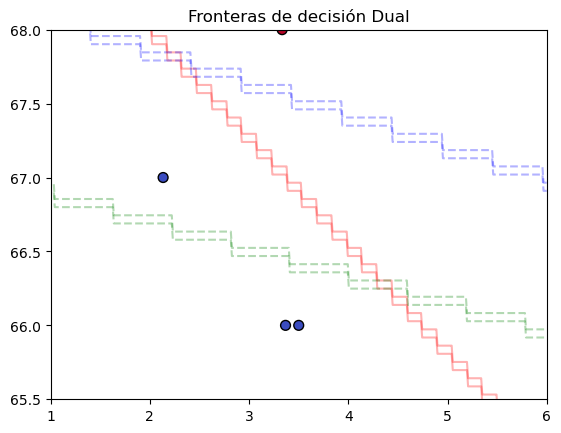

In [226]:


fig2, ax2 = plt.subplots()
ax2.scatter(geyser_ds.values[:, 0], geyser_ds.values[:, 1], c=geyser_ds_labels, cmap="coolwarm", s=50, edgecolors="k")
ax2.contour(xx, yy, Z(dual), levels=[-1, 0, 1], alpha=0.3, colors="red", linestyles="solid")
ax2.contour(xx, yy, Z(dual_soft1), levels=[-1, 0, 1], alpha=0.3, colors="green", linestyles="dashed")
ax2.contour(xx, yy, Z(dual_soft2), levels=[-1, 0, 1], alpha=0.3, colors="blue", linestyles="dashed")
plt.title("Fronteras de decisión Dual")
ax2.set_xlim(1, 6)
ax2.set_ylim(65.5, 68)
plt.show()